### Importing Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.regularizers import l2 

# Load and prepare data
df = pd.read_csv("healthcare_dataset.csv")

In [2]:
df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


# Feature Engineering

### 1. Discount  

In [3]:
# 1. Insurance discounts
insurance_discounts = {
    'Blue Cross': 0.20,
    'Medicare': 0.25,
    'Aetna': 0.15,
    'UnitedHealthcare': 0.18,
    'Cigna': 0.10
}
df['Discounted_Amount'] = df.apply(lambda row: row['Billing Amount'] * 
                         (1 - insurance_discounts.get(row['Insurance Provider'], 0)), axis=1)

### 2. Gender Score Based on Admission

In [4]:
#  Admission scores  (Emergency high because it is life threatening,)
admission_type_scores = {'Emergency': 10, 'Urgent': 7, 'Elective': 3}    
df['Admission_Score'] = df['Admission Type'].map(admission_type_scores)

# Gender scores
gender_scores = {'Male': 5, 'Female': 7.5}
df['Gender_Score'] = df['Gender'].map(gender_scores)
df['Gender_Admission'] = df['Gender_Score'] * df['Admission_Score']


### 3. Medical score based on Disease

In [ ]:
# Medical conditions (Based on severinty) 
disease_scores = {                            
    'Cancer': 10, 'Obesity': 6, 'Diabetes': 7,
    'Asthma': 5, 'Hypertension': 6, 'Arthritis': 4
}
df['Disease_Score'] = df['Medical Condition'].map(disease_scores)

#  Medication scores on a scale of 1-10
medicine_scores = {
    'Paracetamol': 3, 'Ibuprofen': 4, 'Aspirin': 5,
    'Penicillin': 8, 'Lipitor': 7
}
df['Medication'] = df['Medication'].map(medicine_scores)
df['Medication_Score'] = df['Disease_Score'] * df['Medication']


### 4.Time-based features

In [6]:
#  Time-based features
df['Date of Admission'] = pd.to_datetime(df['Date of Admission'])
df['Discharge Date'] = pd.to_datetime(df['Discharge Date'])
df['Time Spent (days)'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

### 5. Age categories (MAKING BINS)

In [7]:
#  Age categories

def age_part(row):
    if row['Age'] < 18: return 'Child'
    elif row['Age'] < 30: return 'Adult'
    elif row['Age'] < 60: return 'Middle-aged'
    else: return 'Old-age'
df['Age-part'] = df.apply(age_part, axis=1)
df.head(5)

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,...,Medication,Test Results,Discounted_Amount,Admission_Score,Gender_Score,Gender_Admission,Disease_Score,Medication_Score,Time Spent (days),Age-part
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,...,3,Normal,15085.025045,7,5.0,35.0,10,30,2,Middle-aged
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,...,4,Inconclusive,25232.495465,10,5.0,50.0,6,24,6,Old-age
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,...,5,Normal,23761.831667,10,7.5,75.0,6,30,15,Old-age
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,...,4,Abnormal,28432.336807,3,7.5,22.5,7,28,30,Adult
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,...,8,Abnormal,12102.570142,7,7.5,52.5,10,80,20,Middle-aged


#### Encoding Data

In [8]:
# First encode target variable

le = LabelEncoder()
df['Test Results_encoded'] = le.fit_transform(df['Test Results'])

# Target encoding for high-cardinality features

for col in ['Doctor', 'Hospital']:
    encoding_map = df.groupby(col)['Test Results_encoded'].mean().to_dict()
    df[f'{col}_encoded'] = df[col].map(encoding_map)

# One-hot encoding for blood type
blood_type_dummies = pd.get_dummies(df['Blood Type'], prefix='blood_type')
df = pd.concat([df, blood_type_dummies], axis=1)

#### Ordinal encoding for age-part

In [9]:

age_order = {'Child': 0, 'Adult': 1, 'Middle-aged': 2, 'Old-age': 3}
df['Age-part'] = df['Age-part'].map(age_order)


#### Interaction features

In [10]:

df['Severity_Score'] = df['Medication_Score'] * df['Gender_Admission']
df['Billing_to_Time_Ratio'] = df['Discounted_Amount'] / (df['Time Spent (days)'] + 1)


#### Drop unnecessary columns

In [11]:

df.drop(columns=[
    'Name', 'Date of Admission', 'Discharge Date', 'Age',
    'Medical Condition', 'Room Number', 'Disease_Score',
    'Gender', 'Admission Type', 'Admission_Score',
    'Insurance Provider', 'Billing Amount', 'Doctor', 'Hospital', 'Blood Type',
    'Test Results'  # Using encoded version instead
], inplace=True)

# Prepare features and target
features = [col for col in df.columns if col != 'Test Results_encoded']
X = df[features]
y = df['Test Results_encoded']


#### Split data ,Scale Feature

In [12]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Prepare target
num_classes = len(le.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Calculate class weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weight_dict = dict(enumerate(class_weights))

#### Build enhanced model

In [13]:

input_shape = (X_train.shape[1],)
model = Sequential([
    Dense(256, activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])


### Compile or Train Model

In [14]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.25,
    verbose=1,
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/50


1041/1041 [==============================] - 10s 7ms/step - loss: 1.5556 - accuracy: 0.8595 - val_loss: 0.4613 - val_accuracy: 0.9494
Epoch 2/50
1041/1041 [==============================] - 7s 6ms/step - loss: 0.3726 - accuracy: 0.9320 - val_loss: 0.2568 - val_accuracy: 0.9560
Epoch 3/50
1041/1041 [==============================] - 7s 6ms/step - loss: 0.3010 - accuracy: 0.9366 - val_loss: 0.2381 - val_accuracy: 0.9542
Epoch 4/50
1041/1041 [==============================] - 6s 6ms/step - loss: 0.2835 - accuracy: 0.9396 - val_loss: 0.2229 - val_accuracy: 0.9573
Epoch 5/50
1041/1041 [==============================] - 7s 6ms/step - loss: 0.2778 - accuracy: 0.9389 - val_loss: 0.2411 - val_accuracy: 0.9483
Epoch 6/50
1041/1041 [==============================] - 6s 6ms/step - loss: 0.2688 - accuracy: 0.9410 - val_loss: 0.2151 - val_accuracy: 0.9554
Epoch 7/50
1041/1041 [==============================] - 8s 8ms/step - loss: 0.2635 - accuracy: 0.9429 - val_loss: 0.2101 - val_accura

#### Evaluation

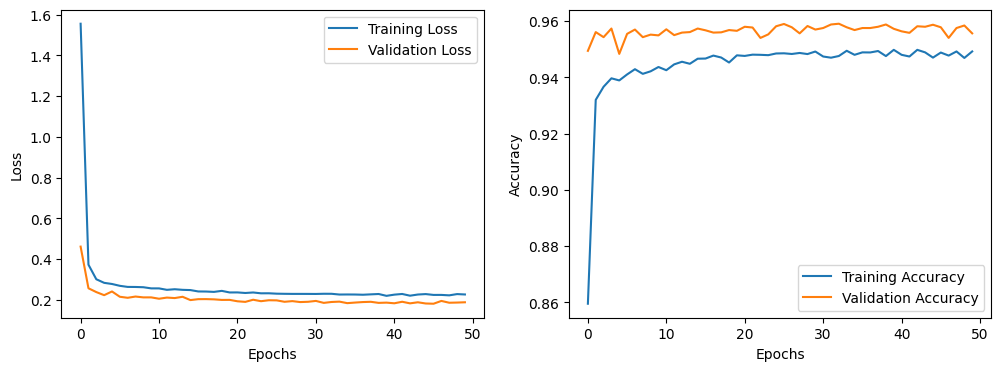

347/347 [==============================] - 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

    Abnormal       0.98      0.96      0.97      3726
Inconclusive       0.92      0.97      0.94      3671
      Normal       0.99      0.96      0.97      3703

    accuracy                           0.96     11100
   macro avg       0.96      0.96      0.96     11100
weighted avg       0.96      0.96      0.96     11100



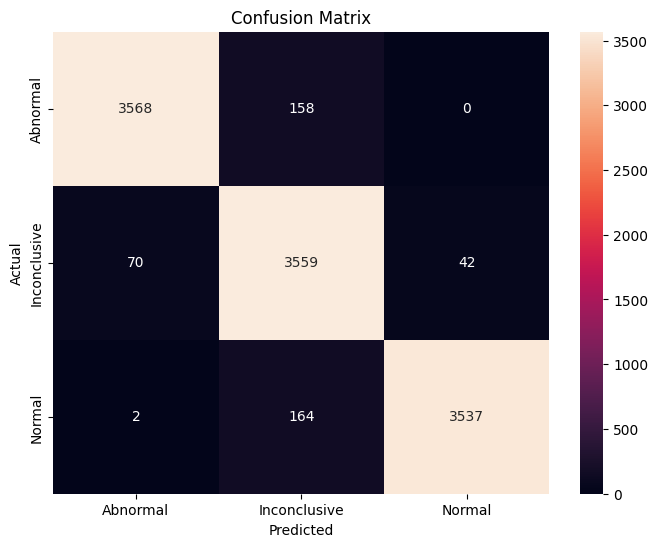

In [15]:

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()